In [27]:
from __future__ import annotations
import operator
from dotenv import load_dotenv
from typing import TypedDict, List, Annotated,Dict

from pydantic import BaseModel, Field

from langgraph.graph import StateGraph, START, END
from langgraph.types import Send
from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage, HumanMessage

load_dotenv()

True

In [57]:
import os

# Create a folder for the generated components
output_dir = "generated_app/components"
os.makedirs(output_dir, exist_ok=True)

In [58]:
import re

def clean_code(text: str) -> str:
    return re.sub(r"```[a-z]*\n|```", "", text).strip()

In [59]:
llm=ChatGroq(
    model='llama-3.3-70b-versatile',
)

In [60]:
DESIGN_SYSTEM = """
Design System Rules:
- Dark theme first (bg-zinc-900, text-white)
- Cards: bg-zinc-800 rounded-2xl shadow-lg p-4
- Use gap-4 or gap-6 for spacing
- Use hover effects and transition
- Modern SaaS style
- Use lucide-react icons only
- No external images
"""

In [61]:
class Component(BaseModel):
    id: int
    name: str
    type: str = Field(..., description="One of: layout, ui, feature")
    description: str
    props: List[str] = Field(default_factory=list)
class Architecture(BaseModel):
    app_name: str
    components: List[Component]

class State(TypedDict):
    request: str
    plan: Architecture
    code_files: Annotated[List[str], operator.add]
    reviews: Annotated[List[str], operator.add]
    final_app: str


In [62]:
def orchestrator(state: State) -> dict:
    """Architect: Designs the component structure."""
    print(f" Designing architecture for: {state['request']}")
    
    plan = llm.with_structured_output(Architecture).invoke(
        [
            SystemMessage(content="""
You are a Senior Frontend Architect at a FAANG company.

Design a scalable, production-level React architecture.

Rules:
- Use Atomic Design principles (Layout, UI, Feature components)
-For every component, you must provide a DEEP description.
- Separate presentational and container logic
- Think about reusability
- Define clear props
- Avoid putting all logic in one component
- Keep components clean and modular
Return structured output.
"""),
            HumanMessage(content=f"Request: {state['request']}"),
        ]
    )
    return {"plan": plan}

In [63]:
def fanout(state: State):
    """The Map Step: Dispatches work to parallel coders.""" 
    return [
        Send("worker", {
            "component": comp, 
            "app_name": state['plan'].app_name,
            "all_components": state['plan'].components
        }) 
        for comp in state['plan'].components
    ]

In [64]:
def worker(payload: dict) -> dict:
    """Worker: Writes high-fidelity code and saves to components folder.""" 
    comp = payload['component']
    app_name = payload['app_name']
    
    # We add "High-Fidelity" instructions to the system rules
    system_rules = f"""
    You are a Senior Frontend Engineer. 
    Design System: {DESIGN_SYSTEM}
    
    Rules:
    1. EXHAUSTIVE DETAIL: Do not write "minimal" or "placeholder" code. 
    2. Implement the FULL description: {comp.description}
    3. Use ONLY standard icons from 'lucide-react'.
    4. You MUST include the import statement for icons at the top.
    5. Use 'export default function {comp.name}'
    6. Use Tailwind CSS for advanced styling (gradients, hover:scale, transitions, glassmorphism).
    7. Return ONLY the component code.
    """

    print(f"  Coding: {comp.name}.jsx")

    response = llm.invoke([
        SystemMessage(content=system_rules),
        HumanMessage(content=f"""
            Project: {app_name}
            Component: {comp.name}
            Props to implement: {comp.props}
            Detailed Requirements: {comp.description}
            
            Instruction: Create a visually stunning, fully functional component. 
            If it's a list, create a beautiful empty state. 
            If it's a card, add shadows, borders, and hover effects.
        """)
    ]).content

    pure_code = clean_code(response)

    os.makedirs("generated_app/components", exist_ok=True)
    file_path = os.path.join("generated_app/components", f"{comp.name}.jsx")
    with open(file_path, "w", encoding="utf-8") as f:
        f.write(pure_code)

    return {"code_files": [comp.name]}

In [65]:
def reviewer(state: State) -> dict:
    print(" Reviewing Components...")

    combined_code = "\n\n".join(state["code_files"])

    review = llm.invoke([
        SystemMessage(content="""
You are a Senior React Code Reviewer.

Check for:
- Missing keys in lists
- Bad prop patterns
- Tailwind misuse
- Accessibility issues
- Reusability issues
- Unnecessary state
- Performance issues

If code is good, say: APPROVED
Else suggest fixes.
"""),
        HumanMessage(content=combined_code)
    ]).content.strip()

    return {"reviews": [review]}

In [66]:
def reducer(state: State) -> dict:
    print(f"  Assembling Modular App: {state['plan'].app_name}...")
    
    app_name = state['plan'].app_name
    # state['code_files'] now contains a list of names like ['MovieGrid', 'MovieCard']
    component_names = state['code_files']
    
    # Generate the import block for the external files
    import_statements = "\n".join([
        f"import {name} from './components/{name}';" 
        for name in component_names
    ])
     
    assembler_prompt = f"""
    You are a Senior React Integrator.
    I have a modular project where these components are already imported: {", ".join(component_names)}.
    
    TASK:
    Write the 'export default function App()'. 

    RULES:
    1. DO NOT define or write the code for {", ".join(component_names)}. Just use them.
    2. Assume they are already imported.
    3. Use 'react-router-dom' for navigation.
    4. Connect the components with state (useState/useEffect) and mock data.
    5. Return ONLY the code for the App component.
    """

    app_logic = llm.invoke([
        SystemMessage(content="Output ONLY the App component code. No markdown."),
        HumanMessage(content=assembler_prompt)
    ]).content

    # The Final Modular App.jsx
    final_source = f"""// APP: {app_name}
import React, {{ useState, useEffect, useMemo }} from 'react';
import {{ BrowserRouter, Routes, Route, Link, useNavigate, useParams }} from 'react-router-dom';
{import_statements}

{clean_code(app_logic)}
    """
    
    # Save the thin main app file
    os.makedirs("generated_app", exist_ok=True)
    with open("generated_app/App.jsx", "w", encoding="utf-8") as f:
        f.write(final_source)
    
    return {"final_app": final_source}

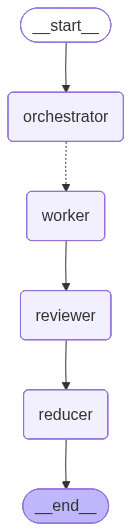

In [67]:
g = StateGraph(State)

g.add_node("orchestrator", orchestrator)
g.add_node("worker", worker)
g.add_node("reviewer", reviewer)
g.add_node("reducer", reducer)

g.add_edge(START, "orchestrator")
g.add_conditional_edges("orchestrator", fanout, ["worker"])
g.add_edge("worker", "reviewer")
g.add_edge("reviewer", "reducer")
g.add_edge("reducer", END)

app = g.compile()
app

In [68]:
out = app.invoke({"request": "Individual product page for cloth website"})

print("\n--- FINAL GENERATED APP ---\n")
print(out['final_app'])

 Designing architecture for: Individual product page for cloth website
  Coding: ProductPageLayout.jsx  Coding: ProductInfo.jsx

  Coding: ProductImageGallery.jsx
  Coding: ProductCTA.jsx
  Coding: ProductPageContainer.jsx
 Reviewing Components...
  Assembling Modular App: Cloth Website...

--- FINAL GENERATED APP ---

// APP: Cloth Website
import React, { useState, useEffect, useMemo } from 'react';
import { BrowserRouter, Routes, Route, Link, useNavigate, useParams } from 'react-router-dom';
import ProductPageLayout from './components/ProductPageLayout';
import ProductInfo from './components/ProductInfo';
import ProductImageGallery from './components/ProductImageGallery';
import ProductCTA from './components/ProductCTA';
import ProductPageContainer from './components/ProductPageContainer';

import { BrowserRouter, Routes, Route } from 'react-router-dom';
import { useState, useEffect } from 'react';

export default function App() {
  const [products, setProducts] = useState([]);
  con